# Deep Learning Methodology

Desigining a model and input pipeline for the data

#### Import libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pymeanshift as pms
import csv
import random
import time
import mlflow.keras
from ipyfilechooser import FileChooser

from tensorflow import keras
from keras import layers

DATA_PATH = "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\image_paths.csv"
SEGMENTED_PATH = "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\image_segmented.csv"
tf.config.list_physical_devices('GPU')
#mlflow.keras.autolog()

fc = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset')
model_file = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\masterthesis\\models')

#### Shuffle

In [2]:
def shuffle_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)
        rows = list(reader)
    random.shuffle(rows)
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(rows)

shuffle_csv(DATA_PATH)

#### Dataset Creation

In [2]:
def load_image(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256], method='nearest')
    image = tf.image.convert_image_dtype(image, tf.float32)

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, [256, 256], method='nearest')
    label = tf.image.convert_image_dtype(label, tf.float32)

    return image, label

def load_dataset(csv_file):
    dataset = tf.data.experimental.CsvDataset(
        csv_file,
        [tf.string, tf.string],
        header=True,
        field_delim=','
    )
    dataset = dataset.map(load_image)
    return dataset

dataset = load_dataset(SEGMENTED_PATH)

In [3]:
dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset.cache('cache/dataset.cache')

<CacheDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>

#### Sanity Check

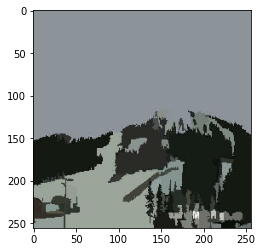

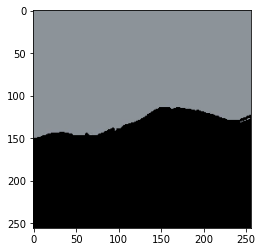

In [4]:
for image, label in dataset.take(1):
    image_masked = image * label # type: ignore
    plt.imshow(image)
    plt.show()
    plt.imshow(image_masked)
    plt.show()

#### Model

In [5]:
def unet_model(input_shape=(256, 256, 3), output_channels=1):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Down-sampling through the model
    skips = []
    for filters in [64, 128, 256, 512]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        skips.append(x)
        x = layers.MaxPooling2D(2)(x)

    # Bottleneck
    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Up-sampling through the model
    for filters, skip in reversed(list(zip([512, 256, 128, 64], skips))):
        x = layers.UpSampling2D(2)(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    # Final layer
    outputs = layers.Conv2D(output_channels, 1)(x)
    outputs = layers.Activation('sigmoid')(outputs)

    return keras.Model(inputs=inputs, outputs=outputs)

#### Dataset Manipulation

In [6]:
#add extra dimension to the dataset
train_dataset = dataset.take(30000).map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))
val_dataset = dataset.skip(30000).take(2000).map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))
test_dataset = dataset.skip(32000).take(6000).map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))

#### Execution

In [16]:
# Create a UNET model
model = unet_model()

# Compile the model with loss and optimizer
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])   #check activation and loss function relationship

# Define a callback to save the model after each epoch
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "models/model_segmented_30000_5.h5", save_freq="epoch"
)

In [17]:
# Train the model on the dataset
model.fit(train_dataset, epochs=5, callbacks=[checkpoint_callback], validation_data=val_dataset, use_multiprocessing=True, workers=4, shuffle=True) 

Epoch 1/5
30000/30000 [==============================] - 4044s 135ms/step - loss: 0.0857 - precision_1: 0.9556 - recall_1: 0.9761 - val_loss: 0.5519 - val_precision_1: 0.8912 - val_recall_1: 0.7952
Epoch 2/5
30000/30000 [==============================] - 4095s 136ms/step - loss: 0.0406 - precision_1: 0.9790 - recall_1: 0.9869 - val_loss: 0.5268 - val_precision_1: 0.8998 - val_recall_1: 0.8012
Epoch 3/5
30000/30000 [==============================] - 4100s 137ms/step - loss: 0.0276 - precision_1: 0.9852 - recall_1: 0.9912 - val_loss: 0.3705 - val_precision_1: 0.9157 - val_recall_1: 0.8349
Epoch 4/5
30000/30000 [==============================] - 4085s 136ms/step - loss: 0.0210 - precision_1: 0.9883 - recall_1: 0.9932 - val_loss: 0.4522 - val_precision_1: 0.8840 - val_recall_1: 0.8480
Epoch 5/5
30000/30000 [==============================] - 4160s 139ms/step - loss: 0.0169 - precision_1: 0.9903 - recall_1: 0.9946 - val_loss: 0.4131 - val_precision_1: 0.9074 - val_recall_1: 0.8657


#### Prediction on Test Dataset

In [1]:
#predict on a single image from the dataset after skipping 10 images
results = []
for image, label in test_dataset:
    image = tf.expand_dims(image, axis=0)
    start = time.time()
    prediction = model.predict(image)

    #mask the image with the prediction
    image_masked = image * prediction # type: ignore
    time_taken = time.time() - start

    #get the precision and recall
    precision = tf.keras.metrics.Precision()
    precision.update_state(label, prediction[0])
    recall = tf.keras.metrics.Recall()
    recall.update_state(label, prediction[0])

    if precision.result().numpy() < 0.9 or recall.result().numpy() < 0.9:
        #get time taken
        print("Precision: ", precision.result().numpy())
        print("Recall: ", recall.result().numpy())
        print("Time taken: ", time_taken)

        plt.imshow(image[0])
        plt.show()
        plt.imshow(label)
        plt.show()
        plt.imshow(image_masked[0])
        plt.show()

    #store results in a numpy array
    results.append([precision.result().numpy(), recall.result().numpy(), time_taken])

NameError: name 'test_dataset' is not defined

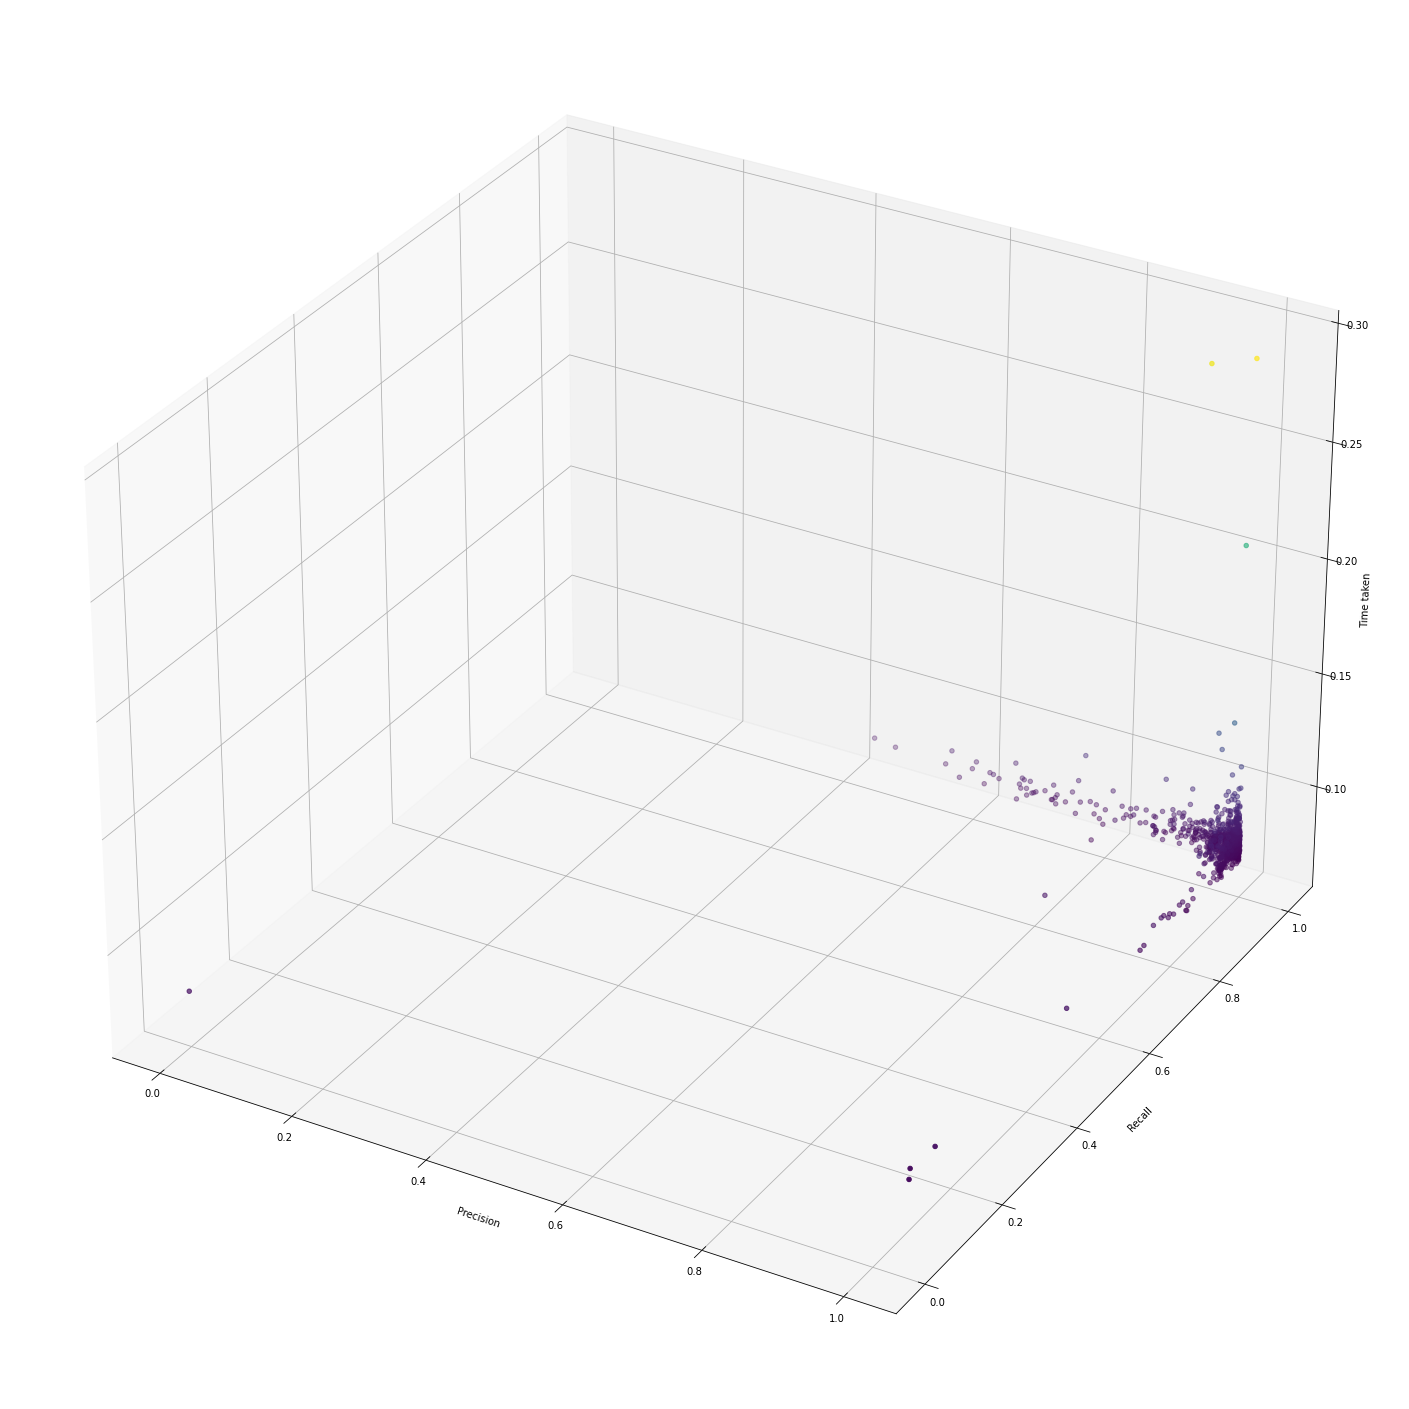

In [52]:
#plot results in a 3D graph
fig = plt.figure(figsize=(25, 30))
ax = fig.add_subplot(111, projection='3d')
results = np.array(results)
ax.scatter(results[:,0], results[:,1], results[:,2], c=results[:,2], cmap='viridis')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_zlabel('Time taken')
plt.show()

#### Prediction on Real-World Data

In [7]:
#choose image file
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset', filename='', title='', show_hidden=False…

In [8]:
#choose model file
display(model_file)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\masterthesis\models', filename='', title='', show_hidde…

In [23]:
#load the mdodel from models/model_13_04_2023.h5
model = keras.models.load_model(model_file.selected)

1/1 [==============================] - 0s 250ms/step


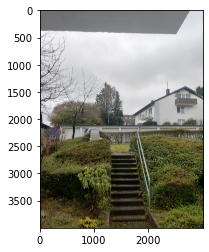

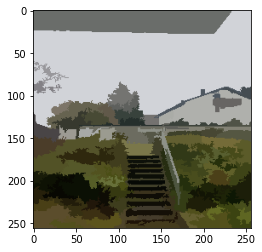

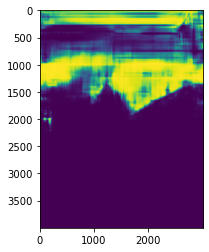

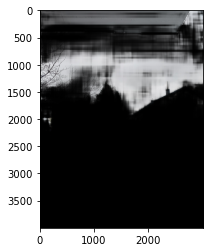

In [24]:
image = tf.io.read_file(fc.selected)
image = tf.image.decode_jpeg(image, channels=3)

#get the shape of the image
original_shape = image.shape
original = image

image = tf.image.resize(image, [256, 256], method='nearest')
if "segmented" in model_file.selected:  
    (image, _, _) = pms.segment(image, spatial_radius=2, range_radius=8, min_density=150)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.expand_dims(image, axis=0)

original = tf.image.convert_image_dtype(original, tf.float32)
original = tf.expand_dims(original, axis=0)

#reshape the prediction to the original shape
prediction = model.predict(image)
prediction = tf.image.resize(prediction, [original_shape[0], original_shape[1]], method='nearest')

image_masked = original * prediction # type: ignore

#reshape the image to the original shape
image_masked = tf.image.resize(image_masked, [original_shape[0], original_shape[1]], method='nearest')

plt.imshow(plt.imread(fc.selected))
plt.show()
plt.imshow(image[0])
plt.show()
plt.imshow(prediction[0])
plt.show()
plt.imshow(image_masked[0])
plt.show()

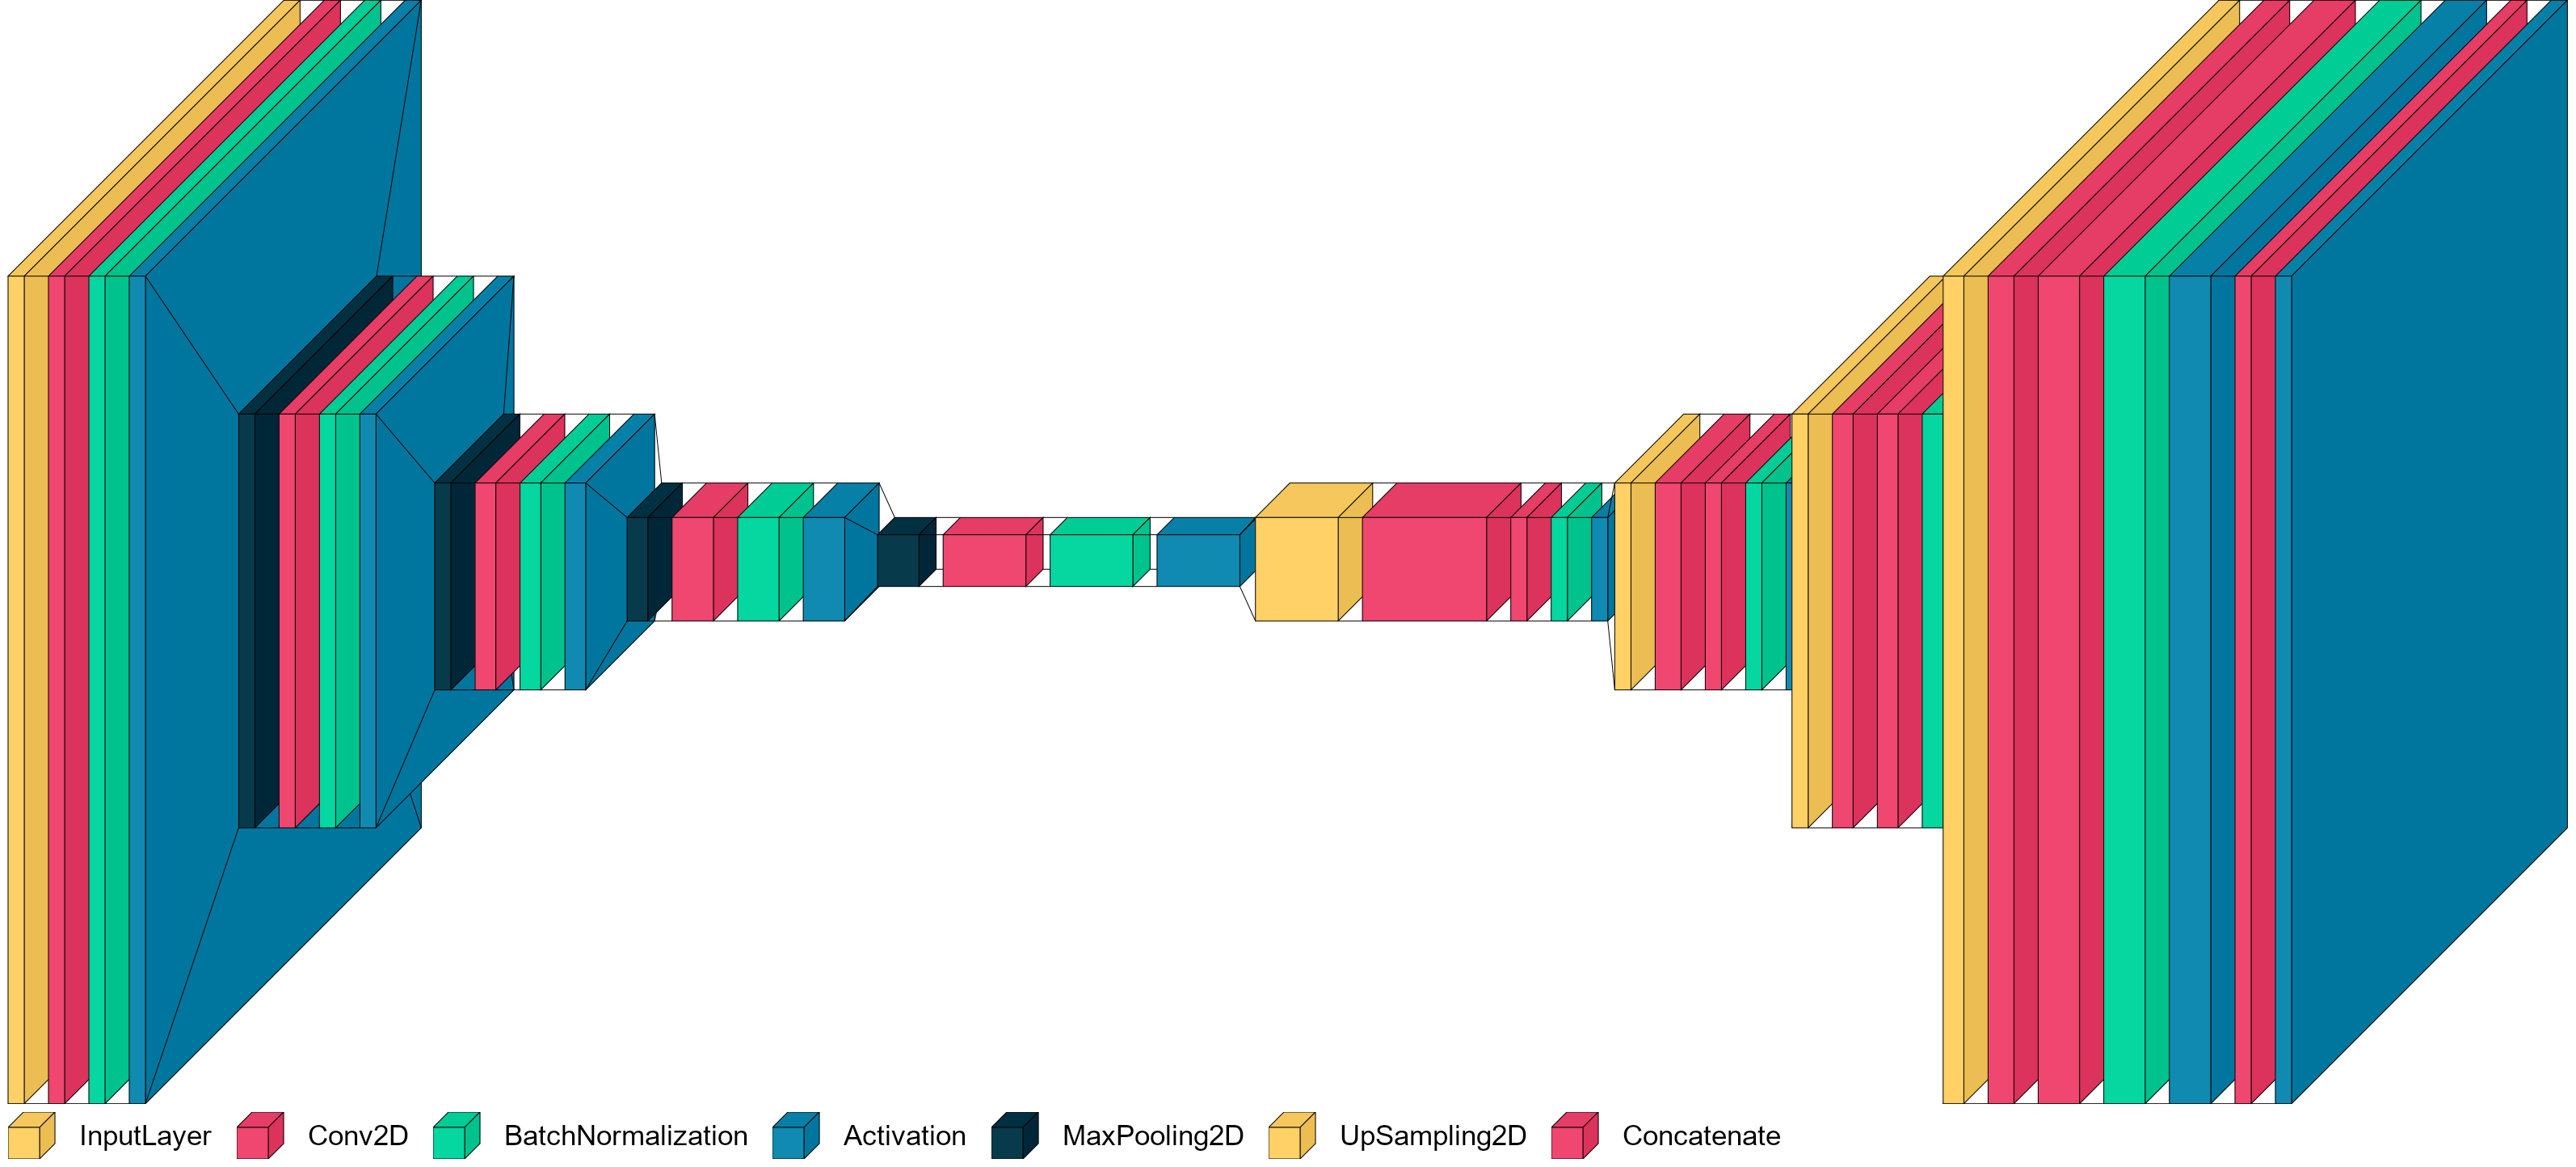

In [13]:
from keras.utils.vis_utils import plot_model
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 35)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False, expand_nested=True, show_layer_activations=False)
visualkeras.layered_view(model, legend=True,spacing=30, font=font)

### Trash

In [104]:
import tensorflow as tf
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv(DATA_PATH)

# Create a list to store the indices of corrupted rows
corrupted_indices = []

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Get the image path and label
    image_path = row['image_path']
    label_path = row['label']

    # Read the image and label files
    image_data = tf.io.read_file(image_path)
    label_data = tf.io.read_file(label_path)

    # Try to decode the image and label data
    try:
        image = tf.io.decode_jpeg(image_data)
        label = tf.io.decode_png(label_data)
        print(f'{image_path} and {label_path} are not corrupted')
    except:
        print(f'{image_path} or {label_path} are corrupted')
        corrupted_indices.append(index)

# Drop the rows containing corrupted paths from the DataFrame
df = df.drop(corrupted_indices)

# Write the updated DataFrame to a new CSV file
df.to_csv('updated.csv', index=False)

C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_084634.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted
C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_091628.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted
C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_114638.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted
C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_125725.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted
C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\10066\20130101_154632.jpg and C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\ValidationImages\Skyfinder\10066.png are not corrupted


In [20]:
import csv
import matplotlib.pyplot as plt
from PIL import Image
import os

def process_image(image_path):
    # Open the image using PIL
    image = plt.imread(image_path)
    
    # Apply some mean shift
    image, _, _ = pms.segment(image, spatial_radius=2, range_radius=8, min_density=150)
    
    return image

# Set the input CSV file path and output directory
input_csv = DATA_PATH
output_dir = 'C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\segemented\\OriginalImages'

# Open the CSV file
with open(input_csv, 'r') as f:
    reader = csv.reader(f)
    
    # Skip the header row
    next(reader)
    
    # Iterate over each row in the CSV file
    for row in reader:
        # Get the image path from the first column
        image_path = row[0]
        
        # Process the image
        processed_image = process_image(image_path)

        # Convert the processed image to a PIL Image
        pil_image = Image.fromarray(processed_image)

        sub_dir = output_dir + "\\" + image_path.split('\\')[-2]
        if not os.path.exists(sub_dir):
            os.makedirs(sub_dir)

        image_name = image_path.split('\\')[-2] + "\\" + image_path.split('\\')[-1]
        pil_image.save(output_dir + "\\" + image_name)

In [2]:
import csv

filename = "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\image_segmented.csv"

with open(filename, 'r') as file:
    reader = csv.reader(file)
    rows = list(reader)

for row in rows:
    row[0] = row[0].replace('dataset', 'segmented')

with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)